In [ ]:
#default_exp poi.train

In [ ]:
from speechsep.imports import *
from speechsep.data import *
from speechsep.core import *
from speechsep.masks import *
from speechsep.utils import *
from speechsep.models import *

/home/cerberus/.anaconda3/envs/fastai/lib/python3.8/site-packages/fastcore/basics.py:790: UserWarning: `patch_property` is deprecated and will be removed; use `patch(as_prop=True)` instead
  warnings.warn("`patch_property` is deprecated and will be removed; use `patch(as_prop=True)` instead")


In [ ]:
from speechsep.base import *

# From the start

In [ ]:
def files2mask(files):
    tfms = [AudioMono.create, Resample(22050), Clip(5)]
    audios = [compose_tfms(f, tfms) for f in files]
    aud2mask = Maskify(MaskBinary)
    mixed_spec, masks = aud2mask(audios)
    return [mixed_spec, masks[0]]

In [ ]:
class POIMesher:
    def __init__(self, poi):
        self.poi = poi

    def get_poi_files(self, path):
        return get_audio_files(path, folders=f"{self.poi}")

    def get_non_poi_files(self, path):
        files = get_audio_files(path)
        poi_path = path/str(self.poi)
        return [file for file in files if poi_path not in list(file.parents)]

    def __call__(self, path):
        rand_poi = []
        poi_files = self.get_poi_files(path)
        non_poi_files = self.get_non_poi_files(path)
        for x in range(len(non_poi_files)):
            rand_poi.append(random.choice(poi_files))
        return list(map(list,zip(rand_poi, non_poi_files)))

In [ ]:
class SpecMaskDataset(torch.utils.data.Dataset):
    def __init__(self, files):
        self.files = files
        self.tensorify = ToTensor()
        self.trim = Unet_Trimmer(16)
        
    def __getitem__(self, i):
        spec, mask = files2mask(self.files[i])
        spec, mask = self.tensorify(spec), self.tensorify(mask)
        return self.trim(spec[:1]), self.trim(mask)
    
    def __len__(self): return len(self.files)

In [ ]:
poi = "911"
fn = Path("/home/cerberus/Music/LibriSpeech/train-clean-100/")

files = POIMesher(poi)(fn)
train_ds = SpecMaskDataset(files)

dls = DataLoaders.from_dsets(train_ds, train_ds, bs=2).cuda()

# Train

In [ ]:
model = U_Net(img_ch=1, output_ch=1).cuda()

In [ ]:
learn = Learner(dls, model, loss_func=MSELossFlat())

In [ ]:
learn.load("TrainBinary4t")

In [ ]:
def listen2spec(spec):
    zeros = torch.zeros_like(spec)
    spec = torch.cat((spec, zeros),0)
    cplx_spec = real2complex(spec)
    specbase = SpecBase(cplx_spec, 22050)
    
    return Spectify().decode(specbase)

def createMask(mask):
    return MaskBinary(mask.numpy(), 0.25)

In [ ]:
i = 0

In [ ]:
dls.dataset[i][0].shape

torch.Size([1, 208, 1024])

In [ ]:
listen2spec(dls.dataset[i][0].cpu())

None, 4.85297052154195secs at 22050 samples per second

In [ ]:
mask = learn.predict([dls.dataset[i][0]])[0].cpu()
mask = createMask(mask)

In [ ]:
listen2spec(dls.dataset[i][0].cpu()*mask)

None, 4.85297052154195secs at 22050 samples per second

In [ ]:
dls.files[i][0]

Path('/home/cerberus/Music/LibriSpeech/train-clean-100/911/128684/911-128684-0068.flac')

In [ ]:
target = dls.dataset[i][1].T.cpu()
target = createMask(target[None,:,:])

In [ ]:
listen2spec(dls.dataset[i][0].cpu()*target)

None, 4.85297052154195secs at 22050 samples per second

<AxesSubplot:>

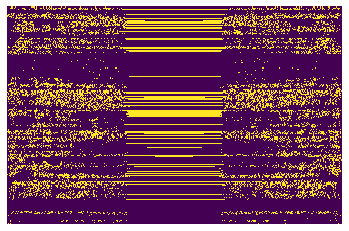

In [ ]:
MaskBinary(target.data[0]).show()

<AxesSubplot:>

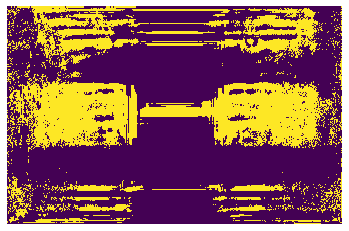

In [ ]:
MaskBinary(mask.data[0],0.22).show_binary()

<AxesSubplot:>

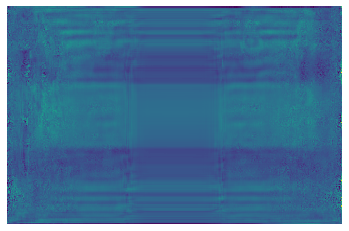

In [ ]:
MaskBinary(mask.data[0]).show()